In [205]:
#Import libraries
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Load Data

In [206]:
#get current working directory and extract needed files(xls and xlsx format)
path = os.getcwd()
files = os.listdir(path)
files_xls = [f for f in files if f[-3:]=='xls' or f[-4:]=='xlsx']

In [207]:
#create empty dataframe
data=pd.DataFrame()

In [208]:
#extract and append data into the created empty dataframe
for f in files_xls:
    raw_data = pd.read_excel(f)
    data = data.append(raw_data)

C:\Users\evang\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


- We keep the columns that are most relevant. Not all columns will be used for this particular analysis. There are a lot of different bookmakers in the data set and a lot of missing odds. Upon a quick visual test, we will keep the two bookmakers that appear the most and have the least missing data (Bet365 and Pinnacle). There is no  bookmaker with completed odds for all matches.

In [209]:
data = data[list(data.columns)[:13]+["Wsets","Lsets","Comment"] +["B365W","B365L","PSW","PSL"]]

In [210]:
data

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL
0,1,Adelaide,AAPT Championships,2001-01-01,International,Outdoor,Hard,1st Round,3,Clement A.,Gaudenzi A.,18.000000,101,2.000000,1.000000,Completed,NaN,NaN,NaN,NaN
1,1,Adelaide,AAPT Championships,2001-01-01,International,Outdoor,Hard,1st Round,3,Goldstein P.,Jones A.,81.000000,442,2.000000,0.000000,Completed,NaN,NaN,NaN,NaN
2,1,Adelaide,AAPT Championships,2001-01-01,International,Outdoor,Hard,1st Round,3,Haas T.,Smith L.,23.000000,485,2.000000,0.000000,Completed,NaN,NaN,NaN,NaN
3,1,Adelaide,AAPT Championships,2001-01-01,International,Outdoor,Hard,1st Round,3,Henman T.,Rusedski G.,10.000000,69,2.000000,0.000000,Completed,NaN,NaN,NaN,NaN
4,1,Adelaide,AAPT Championships,2001-01-01,International,Outdoor,Hard,1st Round,3,Hewitt L.,Arthurs W.,7.000000,83,2.000000,0.000000,Completed,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2,Delray Beach,Delray Beach Open,2021-01-11,ATP250,Outdoor,Hard,Quarterfinals,3,Korda S.,Isner J.,119.000000,25,2.000000,1.000000,Completed,2.100000,1.720000,2.130000,1.800000
54,2,Delray Beach,Delray Beach Open,2021-01-12,ATP250,Outdoor,Hard,Quarterfinals,3,Norrie C.,Tiafoe F.,74.000000,62,2.000000,1.000000,Completed,2.100000,1.720000,2.030000,1.880000
55,2,Delray Beach,Delray Beach Open,2021-01-12,ATP250,Outdoor,Hard,Semifinals,3,Hurkacz H.,Harrison C.,35.000000,280,2.000000,0.000000,Completed,1.360000,3.200000,1.410000,3.180000
56,2,Delray Beach,Delray Beach Open,2021-01-13,ATP250,Outdoor,Hard,Semifinals,3,Korda S.,Norrie C.,119.000000,74,2.000000,0.000000,Completed,1.660000,2.200000,1.760000,2.190000


## Cleaning

In [211]:
data["Comment"].value_counts()

Completed       48561
Retired          1589
Walkover          255
Disqualified        2
Awarded             1
Sched               1
Name: Comment, dtype: int64

- We only keep the matches that are either completed or retired with at least one game played  or walkover with at least one game played.

In [212]:
condition_1 = data['Comment'] == 'Completed'
condition_2 = (data['Comment'] == 'Retired') & ( (data['Wsets'].isin([1, 2, 3]) | (data['Lsets'].isin([1, 2, 3]))) ) 
condition_3 = (data['Comment'] == 'Walkover') & ( (data['Wsets'].isin([1, 2, 3]) | (data['Lsets'].isin([1, 2, 3]))) )

In [213]:
data=data[condition_1 | condition_2 | condition_3]

In [214]:
#Perfom necessary cleaning of the data for our analysis. Focus on relevant columns for our analysis.
data=data.sort_values("Date")    #sort data frame by date
data["Surface"].str.replace("'b", "")    #drop the b' prefix from the Surface column
data['Winner']=data['Winner'].str.strip()    #remove leading and trailing whitespaces from names
data['Loser']=data['Loser'].str.strip()
data=data.reset_index(drop=True)

In [215]:
print("The total number of matches is: " + str(len(data)))

The total number of matches is: 49854


## Implement Elo Model

In [216]:
def get_elo_rankings(data):
    """
    Function that given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match.
    
    Parameters: data(pandas DataFrame) - DataFrame that contains needed information on tennis matches, e.g players names,
    winners, losesrs , surfaces etc
    
    Return: elo_ranking(pandas DataFrame) - DataFrame that contains the calculated Elo Ratings and the Pwin.
    
    """    
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)    #create list of all players
    elo=pd.Series(np.ones(len(players))*1500,index=players)    #create series with initialised elo rating for all players
    matches_played=pd.Series(np.zeros(len(players)), index=players)    #create series with players' matches initialised at 0 and updated after each match
    ranking_elo=[(1500,1500)]    #create initial elo's list
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner    #identify winning player
        l=data.iloc[i-1,:].Loser    #identify losing player
        elow=elo[w]
        elol=elo[l]
        matches_played_w=matches_played[w]
        matches_played_l=matches_played[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    #compute prob of winner to win    
        K_win=250/((matches_played_w+5)**0.4)    #K-factor of winning player
        K_los=250/((matches_played_l+5)**0.4)   #K-factor of losing player
        new_elow=elow+K_win*(1-pwin)   #winning player new elo 
        new_elol=elol-K_los*(1-pwin)   #losing player new elo
        elo[w]=new_elow
        elo[l]=new_elol
        matches_played[w]+=1   #update total matches of players
        matches_played[l]+=1
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser]))         
    ranking_elo=pd.DataFrame(ranking_elo,columns=["Elo_Winner","Elo_Loser"])    
    ranking_elo["Prob_Elo"]=1 / (1 + 10 ** ((ranking_elo["Elo_Loser"] - ranking_elo["Elo_Winner"]) / 400))   
    return ranking_elo

In [217]:
elo_rankings = get_elo_rankings(data)
data = pd.concat([data,elo_rankings],1) 

In [218]:
print(data[["Elo_Winner", "Elo_Loser", "Prob_Elo"]])

       Elo_Winner   Elo_Loser  Prob_Elo
0     1500.000000 1500.000000  0.500000
1     1500.000000 1500.000000  0.500000
2     1500.000000 1500.000000  0.500000
3     1500.000000 1500.000000  0.500000
4     1500.000000 1500.000000  0.500000
...           ...         ...       ...
49849 1739.652128 1648.740428  0.627926
49850 1753.113133 1793.570316  0.442039
49851 1881.881894 1842.267327  0.556764
49852 1794.316822 1709.224513  0.620067
49853 1754.894556 1826.469047  0.398429

[49854 rows x 3 columns]


## Testing Period 

- Sort the data in chronological order (2001-2021 with 2003 missing). Use the period 2001-2010, half of the total, to "train" the Elo Ratings. Keep the 2011-2021 data to test how well your modle works.

In [219]:
beg = datetime.datetime(2011,1,1) 
end = data.Date.iloc[-1]
indices = data[(data.Date>beg)&(data.Date<=end)].index

In [220]:
data_test = data.iloc[indices,:].reset_index(drop=True)
print("The initial number of matches during the testing period is: " +str(len(data_test)))
print("The Bet365 and Pinnacle odds columns contain missing values ==> Delete rows that contain missing values so we can compare later the odds")
data_test = data_test.replace(0,np.nan)
data_test.dropna(inplace=True)
data_test.reset_index(drop=True)

The initial number of matches during the testing period is: 24670
The Bet365 and Pinnacle odds columns contain missing values ==> Delete rows that contain missing values so we can compare later the odds


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL,Elo_Winner,Elo_Loser,Prob_Elo
0,2,Chennai,Chennai Open,2011-01-03,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,...,2.000000,1.000000,Completed,3.250000,1.330000,3.290000,1.370000,1595.832472,1796.084658,0.239988
1,1,Brisbane,Brisbane International,2011-01-03,ATP250,Outdoor,Hard,1st Round,3,Berrer M.,...,2.000000,1.000000,Completed,1.830000,1.830000,1.980000,1.910000,1602.216209,1628.965804,0.461580
2,2,Chennai,Chennai Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Haase R.,...,2.000000,1.000000,Completed,1.330000,3.250000,1.360000,3.380000,1593.762427,1632.508970,0.444469
3,2,Chennai,Chennai Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Sugita Y.,...,2.000000,1.000000,Completed,2.000000,1.720000,2.050000,1.850000,1421.441679,1485.316048,0.409099
4,3,Doha,Qatar Exxon Mobil Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Chiudinelli M.,...,2.000000,1.000000,Completed,1.200000,4.330000,1.230000,4.630000,1613.728799,1549.590618,0.591268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,1,Antalya,Antalya Open,2021-01-11,ATP250,Indoor,Hard,Quarterfinals,3,Chardy J.,...,2.000000,1.000000,Completed,2.620000,1.500000,2.860000,1.480000,1783.951622,1771.802523,0.517477
9396,2,Delray Beach,Delray Beach Open,2021-01-11,ATP250,Outdoor,Hard,Quarterfinals,3,Korda S.,...,2.000000,1.000000,Completed,2.100000,1.720000,2.130000,1.800000,1739.012217,1835.751709,0.364270
9397,2,Delray Beach,Delray Beach Open,2021-01-12,ATP250,Outdoor,Hard,Quarterfinals,3,Norrie C.,...,2.000000,1.000000,Completed,2.100000,1.720000,2.030000,1.880000,1686.364900,1756.336473,0.400642
9398,1,Antalya,Antalya Open,2021-01-12,ATP250,Indoor,Hard,Semifinals,3,Bublik A.,...,2.000000,1.000000,Completed,1.400000,3.000000,1.500000,2.800000,1753.113133,1793.570316,0.442039


In [221]:
print("The number of tested matches is: "+str(len(data_test)))

The number of tested matches is: 9400


# Assess the Model

## Percentage of games correctly predicted

- The way we made our calculations Pwin indicates the probability of the actual winner to win the match prior to the beginning of the match. In this way it is easy to calculate different metrics for our model as the outcome will be 1(win) in all matches.

In [222]:
winners_prob_elo = [x for x in data_test['Prob_Elo'] if x>0.5]
print("Total number of correctly predicted matches: "+str(len(winners_prob_elo)))

Total number of correctly predicted matches: 5778


In [223]:
pred_accur = len(winners_prob_elo)/len(data_test)
print("The percentage of correctly predicted games outcome is: %5.3f" % pred_accur)

The percentage of correctly predicted games outcome is: 0.615


## MAE

In [254]:
error = [1-x for x in winners_prob_elo]
avg_error_parts = [x/len(winners_prob_elo) for x in error]
MAE = sum(avg_error_parts)
print("The Mean Absolute Error is: %5.3f" % MAE)

The Mean Absolute Error is: 0.290


## Log loss

In [225]:
from sklearn.metrics import log_loss

In [226]:
#Calculate log loss for Elo model predictions
outcome = [1]*len(data_test)
all_pwin = [x for x in data_test['Prob_Elo']]
losses_1 = [log_loss([1], [x], labels=[0,1]) for x in all_pwin]

In [227]:
logloss = sum(losses_1)/len(losses_1)
print("The Log loss for our Elo model is: %5.3f" % logloss)

The Log loss for our Elo model is: 0.678


In [228]:
def get_prob(a):
    '''Function that convert decimal odds to probabilities.
       Parameters: a - decimal odd (float) 
       Return: a - probability (float)
    '''
    a=1/a
    return a  

In [229]:
#covert decimal odds to probabilities
data_test[["B365W","PSW"]]=data_test[["B365W","PSW"]].apply(get_prob)

In [230]:
#Calculate Log loss for Bet365 odds
B365_odds = [x for x in data_test["B365W"]]
losses_1B =[log_loss([1], [x], labels=[1,0]) for x in B365_odds]
loglossB = sum(losses_1B)/len(losses_1B)
print("The log loss of the Bet365 odds is: %5.3f" %loglossB)

The log loss of the Bet365 odds is: 0.579


In [231]:
#Calculate the Log loss for Pinnacle odds
PS_odds = [x for x in data_test["PSW"]]
losses_1P =[log_loss([1], [x], labels=[1,0]) for x in PS_odds]
loglossP = sum(losses_1P)/len(losses_1P)
print("The log loss of the PS odds is: %5.3f" %loglossP)

The log loss of the PS odds is: 0.619


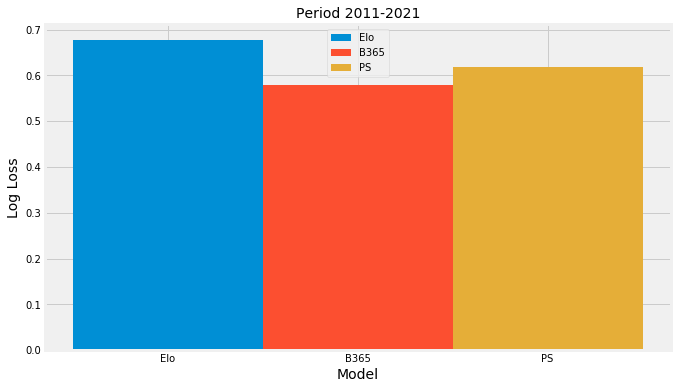

In [232]:
#Plot log loss results to compare
loglosses = [logloss,loglossB, loglossP]
fig, ax=plt.subplots(figsize=(10,6))
barwidth = 0.2
labels = ["Elo", "B365", "PS"]
br1 = np.arange(1)
br2 = [x + barwidth for x in br1]
br3 = [x + barwidth for x in br2]
plt.bar(br1, logloss, width =barwidth, label="Elo")
plt.bar(br2, loglossB, width=barwidth, label="B365")
plt.bar(br3, loglossP, width=barwidth, label="PS")
plt.xlabel("Model", fontsize=14)
plt.ylabel("Log Loss", fontsize=14)
plt.title("Period 2011-2021", fontsize=14)
ax.set_xticks(np.arange(0,0.6,0.2))
ax.set_xticklabels(labels)
plt.legend()
plt.show()

# Correlation of Players' Perfomances on Different Surfaces

- In this we will calculate the correlation of the perfomance of players between tha three main surfaces: Grass, Clay, Hard

In [233]:
winners = np.unique(data.Winner)
losers = np.unique(data.Loser)
players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) 
record = np.zeros(len(players))    #general record of players' matches
Clay_record =  np.zeros(len(players))    # Clay Record
Grass_record = np.zeros(len(players))    # Grass Record
Hard_record = np.zeros(len(players))    #Hard surface record

In [234]:
d = {'Player_name': players, 'record':record, 'Clay_record': Clay_record,
     'Grass_record':Grass_record,'Hard_record':Hard_record}
players_df = pd.DataFrame(data=d)

In [235]:
print("The total number of players is: "+str(len(players)))

The total number of players is: 1390


In [236]:
# Fill in features values for each feature
for i,row in enumerate(players_df.iterrows()):
    w = len(data[data.Winner == row[1].Player_name])
    l = len(data[data.Loser == row[1].Player_name])
    players_df.loc[i,'Total_Games'] = w + l
    players_df.loc[i,'record'] = np.true_divide(w,(w+l))    
     
    temp_df = data[data.Surface == "Clay"]
    w = len(temp_df[temp_df.Winner == row[1].Player_name])
    l = len(temp_df[temp_df.Loser == row[1].Player_name])
    players_df.loc[i,'Total_Clay_Games'] = w + l
    players_df.loc[i,'Clay_record'] = np.true_divide(w,(w+l))
    
    temp_df = data[data.Surface == 'Grass']
    w = len(temp_df[temp_df.Winner == row[1].Player_name])
    l = len(temp_df[temp_df.Loser == row[1].Player_name])
    players_df.loc[i,'Total_Grass_Games'] = w + l
    players_df.loc[i,'Grass_record'] = np.true_divide(w,(w+l))
    
    temp_df = data[data.Surface == 'Hard']
    w = len(temp_df[temp_df.Winner == row[1].Player_name])
    l = len(temp_df[temp_df.Loser == row[1].Player_name])
    players_df.loc[i,'Total_Hard_Games'] = w + l
    players_df.loc[i,'Hard_record'] = np.true_divide(w,(w+l))

C:\Users\evang\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\evang\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\evang\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [237]:
players_df

,Player_name,record,Clay_record,Grass_record,Hard_record,Total_Games,Total_Clay_Games,Total_Grass_Games,Total_Hard_Games
0,Federer R.,0.843106,0.790984,0.887701,0.849682,1262.000000,244.000000,187.000000,785.000000
1,Nadal R.,0.835409,0.926009,0.784091,0.778547,1124.000000,446.000000,88.000000,578.000000
2,Djokovic N.,0.832234,0.808989,0.850467,0.844444,1061.000000,267.000000,107.000000,675.000000
3,Ferrer D.,0.666998,0.711538,0.625000,0.645545,1006.000000,416.000000,64.000000,505.000000
4,Verdasco F.,0.567597,0.612188,0.550562,0.536957,932.000000,361.000000,89.000000,460.000000
...,...,...,...,...,...,...,...,...,...
1385,Prashanth V.,0.000000,NaN,NaN,0.000000,1.000000,0.000000,0.000000,1.000000
1386,Kim K,0.000000,NaN,0.000000,NaN,1.000000,0.000000,1.000000,0.000000
1387,Hood M.,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000
1388,Moraru G.,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000


- We keep only the players that have played at least 15 games in total and at least 3 games in each surface for better correlation results. 

In [238]:
players_df = players_df.loc[(players_df["Total_Games"]>15) & (players_df["Total_Grass_Games"]>3) & (players_df["Total_Hard_Games"]>3) & (players_df["Total_Clay_Games"]>3)]

In [239]:
players_df.isnull().sum()

Player_name          0
record               0
Clay_record          0
Grass_record         0
Hard_record          0
Total_Games          0
Total_Clay_Games     0
Total_Grass_Games    0
Total_Hard_Games     0
dtype: int64

- Now there are no NaNs resulted from players that had zero games in either one of the surfaces in our data

In [240]:
print("The total number of players that their results we examine is: " +str(len(players_df)))

The total number of players that their results we examine is: 375


In [241]:
hard_clay_corr = players_df['Hard_record'].corr(players_df["Clay_record"],method="pearson")
print("The correlation of players' perfomance between Hard and Clay surface is: %5.3f" %hard_clay_corr)

The correlation of players' perfomance between Hard and Clay surface is: 0.476


In [242]:
grass_clay_corr = players_df['Grass_record'].corr(players_df["Clay_record"],method="pearson")
print("The correlation of players' perfomance between Grass and Clay surface is: %5.3f" %grass_clay_corr)

The correlation of players' perfomance between Grass and Clay surface is: 0.276


In [243]:
grass_hard_corr = players_df['Grass_record'].corr(players_df["Hard_record"],method="pearson")
print("The correlation of players' perfomance between Grass and Hard surface is: %5.3f" %grass_hard_corr)

The correlation of players' perfomance between Grass and Hard surface is: 0.641


# Implementation of a Surface Adjusted Elo model 

Given the above information we conclude that tennis players performance varies across surfaces. Their performance in Grass and Hard surfaces is highly correlated whereas in Grass and Clay is not. To incorporate that in our Elo model we will implement an adjusted Elo model that considers the surface that the game is played. For that we will calculate each player's Elo rating in the three main surfaces alongside their standard Elo and combine them to derive a more accurate prediction.

- We make the simplest adjustment to weight each type of Elo equally. So we take the midpoint of the standard Elo and the surface specific Elo. This implementation may not be optimal and further exploration is needed so the optimal weights, regarding model prediction parfomance, can be derived.

In [244]:
lamda=0.5  #surface adjusted Elo parameter - determines the weight of the surface Elo

In [245]:
def get_adj_elo_rankings(data):
    """
    Function that given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    Paremeters: data - pandas DataFrame
    
    Return: ranking_elo - pandas DataFrame
    """    
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)    #create list of all players
    elo=pd.Series(np.ones(len(players))*1500,index=players)    #create series with initialised elo rating for all players
    adj_elo=pd.Series(np.ones(len(players))*1500,index=players)    #series to initialise adjusted elos
    elo_clay=pd.Series(np.ones(len(players))*1500,index=players)   #initialise clay specific elos
    elo_hard=pd.Series(np.ones(len(players))*1500,index=players)    #initialise hard specific elos
    elo_grass=pd.Series(np.ones(len(players))*1500,index=players)    #initialise grass specific elos
    matches_played=pd.Series(np.zeros(len(players)), index=players)    #create series with players' matches initialised at 0 and updated after each match
    matches_played_hard=pd.Series(np.zeros(len(players)), index=players)   #initialise number of matches in specific surfaces for players
    matches_played_clay=pd.Series(np.zeros(len(players)), index=players)
    matches_played_grass=pd.Series(np.zeros(len(players)), index=players)
    ranking_elo=[(1500,1500)]    #create initial elos list
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner    #identify winning player
        l=data.iloc[i-1,:].Loser    #identify losing player
        elow=elo[w]
        elol=elo[l]
        matches_played_w=matches_played[w]
        matches_played_l=matches_played[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    #compute prob of winner to win    
        K_win=250/((matches_played_w+5)**0.4)    #K-factor of winning player
        K_los=250/((matches_played_l+5)**0.4)   #K-factor of losing player
        new_elow=elow+K_win*(1-pwin)   #winning player new elo 
        new_elol=elol-K_los*(1-pwin)   #losing player new elo
        elo[w]=new_elow
        elo[l]=new_elol
        matches_played[w]+=1   #update total matches of players
        matches_played[l]+=1
        surface = data.iloc[i-1,:].Surface    #identify the surface of each match
        #Grass
        if  surface == "Grass":           
            elo_grassw=elo_grass[w]
            elo_grassl=elo_grass[l]
            matches_played_grassw=matches_played_grass[w]
            matches_played_grassl=matches_played_grass[l]
            adj_elow =adj_elo[w]
            adj_elol = adj_elo[l] 
            pwin=1 / (1 + 10 ** ((adj_elol - adj_elow) / 400))    #alternate pwin given the grass-surface adgusted elos
            K_grass_win=250/((matches_played_grassw+5)**0.4)    #compute K-factor specific for Grass surface
            K_grass_los=250/((matches_played_grassl+5)**0.4)
            new_elo_grassw=elo_grassw+K_grass_win*(1-pwin)    #update surface specific elo rating 
            new_elo_grassl=elo_grassl+K_grass_los*(1-pwin)
            elo_grass[w]=new_elo_grassw
            elo_grass[l]=new_elo_grassl
            adj_elo[w]=lamda*new_elo_grassw +(1-lamda)*new_elow    #calculate new adj-elo of the players
            adj_elo[l]=lamda*new_elo_grassl +(1-lamda)*new_elol
            matches_played_grass[w]+=1    #update total matches on Hard surface for the players 
            matches_played_grass[l]+=1    
            ranking_elo.append((adj_elo[data.iloc[i,:].Winner],adj_elo[data.iloc[i,:].Loser]))
        #Hard   
        elif surface == "Hard":           
            elo_hardw=elo_hard[w]
            elo_hardl=elo_hard[l]
            matches_played_hardw=matches_played_hard[w]
            matches_played_hardl=matches_played_hard[l]
            adj_elow =adj_elo[w]
            adj_elol = adj_elo[l] 
            pwin=1 / (1 + 10 ** ((adj_elol - adj_elow) / 400))    #alternate pwin given the hard-surface adgusted elos
            K_hard_win=250/((matches_played_hardw+5)**0.4)    #compute K-factor specific for Hard surface
            K_hard_los=250/((matches_played_hardl+5)**0.4)
            new_elo_hardw=elo_hardw+K_hard_win*(1-pwin)    #update surface specific elo rating 
            new_elo_hardl=elo_hardl+K_hard_los*(1-pwin)
            elo_hard[w]=new_elo_hardw
            elo_hard[l]=new_elo_hardl
            adj_elo[w]=(lamda)*new_elo_hardw +(1-lamda)*new_elow    #calculate new adj-elo of the players
            adj_elo[l]=(lamda)*new_elo_hardl +(1-lamda)*new_elol
            matches_played_hard[w]+=1    #update total matches on Hard surface for the players 
            matches_played_hard[l]+=1    
            ranking_elo.append((adj_elo[data.iloc[i,:].Winner],adj_elo[data.iloc[i,:].Loser]))    
        #Clay    
        elif surface == "Clay":
            elo_clayw=elo_clay[w]
            elo_clayl=elo_clay[l]
            matches_played_clayw=matches_played_clay[w]
            matches_played_clayl=matches_played_clay[l]
            adj_elow=adj_elo[w]
            adj_elol=adj_elo[l]
            pwin=1 / (1 + 10 ** ((adj_elol - adj_elow) / 400))    #alternate pwin given the clay-surface adjusted elos
            K_clay_win=250/((matches_played_clayw+5)**0.4)
            K_clay_los=250/((matches_played_clayl+5)**0.4)
            new_elo_clayw=elo_clayw+K_clay_win*(1-pwin) 
            new_elo_clayl=elo_clayl+K_clay_los*(1-pwin)
            elo_clay[w]=new_elo_clayw
            elo_clay[l]=new_elo_clayl
            adj_elo[w] = lamda*new_elo_clayw+(1-lamda)*new_elow    
            adj_elo[l] = lamda*new_elo_clayl+(1-lamda)*new_elol 
            matches_played_clay[w]+=1
            matches_played_clay[l]+=1
            ranking_elo.append((adj_elo[data.iloc[i,:].Winner],adj_elo[data.iloc[i,:].Loser]))
        #Carpet    
        else:       
            adj_elo[w]=new_elow
            adj_elo[l]=new_elol
            ranking_elo.append((adj_elo[data.iloc[i,:].Winner], adj_elo[data.iloc[i,:].Loser]))
    ranking_elo=pd.DataFrame(ranking_elo,columns=["Adj_Elo_Winner","Adj_Elo_Loser"])  
    ranking_elo["Prob_Adj_Elo"]=1 / (1 + 10 ** ((ranking_elo["Adj_Elo_Loser"] - ranking_elo["Adj_Elo_Winner"]) / 400))
    return ranking_elo

In [246]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)    #convert to float format to avoid scientific notation

In [247]:
adj_elo_rankings = get_adj_elo_rankings(data)
print(adj_elo_rankings[["Adj_Elo_Winner", "Adj_Elo_Loser", "Prob_Adj_Elo"]])

       Adj_Elo_Winner  Adj_Elo_Loser  Prob_Adj_Elo
0         1500.000000    1500.000000      0.500000
1         1500.000000    1500.000000      0.500000
2         1500.000000    1500.000000      0.500000
3         1500.000000    1500.000000      0.500000
4         1500.000000    1500.000000      0.500000
...               ...            ...           ...
49849     2444.294981    1742.036003      0.982750
49850     2481.240963    4112.626365      0.000083
49851     3054.995470    3958.461429      0.005482
49852     1798.468962    2614.918556      0.009015
49853     2452.314946    1862.015183      0.967643

[49854 rows x 3 columns]


## Testig Period 

In [248]:
#Testing Period
beg = datetime.datetime(2011,1,1) 
indices = data[(data.Date>beg)&(data.Date<=end)].index
#concat elo rabkings to test data set
data = pd.concat([data,adj_elo_rankings],1)
#clean test data set
data_test = data.iloc[indices,:].reset_index(drop=True)
print("The initial number of matches during the testing period is: " +str(len(data_test)))
print("The Bet365 and Pinnacle odds columns contain missing values ==> Delete rows that contain missing values so we can compare later the odds")
data_test = data_test.replace(0,np.nan)
data_test.dropna(inplace=True)
data_test.reset_index(drop=True)

The initial number of matches during the testing period is: 24670
The Bet365 and Pinnacle odds columns contain missing values ==> Delete rows that contain missing values so we can compare later the odds


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,B365W,B365L,PSW,PSL,Elo_Winner,Elo_Loser,Prob_Elo,Adj_Elo_Winner,Adj_Elo_Loser,Prob_Adj_Elo
0,2,Chennai,Chennai Open,2011-01-03,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,...,3.250000,1.330000,3.290000,1.370000,1595.832472,1796.084658,0.239988,2219.062169,3033.656760,0.009110
1,1,Brisbane,Brisbane International,2011-01-03,ATP250,Outdoor,Hard,1st Round,3,Berrer M.,...,1.830000,1.830000,1.980000,1.910000,1602.216209,1628.965804,0.461580,2435.904788,2580.904839,0.302655
2,2,Chennai,Chennai Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Haase R.,...,1.330000,3.250000,1.360000,3.380000,1593.762427,1632.508970,0.444469,2059.752953,2176.755034,0.337710
3,2,Chennai,Chennai Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Sugita Y.,...,2.000000,1.720000,2.050000,1.850000,1421.441679,1485.316048,0.409099,1470.209631,1669.130960,0.241388
4,3,Doha,Qatar Exxon Mobil Open,2011-01-04,ATP250,Outdoor,Hard,1st Round,3,Chiudinelli M.,...,1.200000,4.330000,1.230000,4.630000,1613.728799,1549.590618,0.591268,2373.137002,1627.736740,0.986492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,1,Antalya,Antalya Open,2021-01-11,ATP250,Indoor,Hard,Quarterfinals,3,Chardy J.,...,2.620000,1.500000,2.860000,1.480000,1783.951622,1771.802523,0.517477,4107.439900,3502.233288,0.970225
9396,2,Delray Beach,Delray Beach Open,2021-01-11,ATP250,Outdoor,Hard,Quarterfinals,3,Korda S.,...,2.100000,1.720000,2.130000,1.800000,1739.012217,1835.751709,0.364270,1721.053265,4706.776473,0.000000
9397,2,Delray Beach,Delray Beach Open,2021-01-12,ATP250,Outdoor,Hard,Quarterfinals,3,Norrie C.,...,2.100000,1.720000,2.030000,1.880000,1686.364900,1756.336473,0.400642,2586.394622,2795.381126,0.230938
9398,1,Antalya,Antalya Open,2021-01-12,ATP250,Indoor,Hard,Semifinals,3,Bublik A.,...,1.400000,3.000000,1.500000,2.800000,1753.113133,1793.570316,0.442039,2481.240963,4112.626365,0.000083


## Assess the Model

In [255]:
winners_prob_adj_elo = [x for x in data_test['Prob_Adj_Elo'] if x>0.5]
print("Total number of correctly predicted matches: "+str(len(winners_prob_adj_elo)))

pred_accur_adj = len(winners_prob_adj_elo)/len(data_test)
print("The percentage of correctly predicted games outcome is: %5.3f" % pred_accur_adj)

error_adj = [1-x for x in winners_prob_adj_elo]
avg_error_parts_adj = [x/len(winners_prob_adj_elo) for x in error_adj]
MAE = sum(avg_error_parts_adj)
print("The Mean Absolute Error is: %5.3f" % MAE)

#Calculate log loss for Elo model predictions
outcome = [1]*len(data_test)
all_pwin = [x for x in data_test['Prob_Adj_Elo']]
losses_1adj = [log_loss([1], [x], labels=[0,1]) for x in all_pwin]

logloss = sum(losses_1adj)/len(losses_1adj)
print("The Log loss for our Surface Adjusted Elo model is: %5.3f" % logloss)

Total number of correctly predicted matches: 5419
The percentage of correctly predicted games outcome is: 0.576
The Mean Absolute Error is: 0.091
The Log loss for our Surface Adjusted Elo model is: 2.008
